In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
import scipy.signal
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import opening, binary_erosion, binary_opening, binary_closing

import modules.utils as utils

# https://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

# Image Thresholding

In [3]:
def otsu_thresholding(img, show=False):
    _, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_TOZERO)
    _, img_otsu_binary = cv2.threshold(img_otsu, 0, 255, cv2.THRESH_BINARY_INV)
    
    if show:
        fig, ax = plt.subplots(1,3,figsize=(18,12))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original")
        ax[1].imshow(img_otsu, cmap=plt.cm.gray)
        ax[1].set_title("Otsu To Zero")
        ax[2].imshow(img_otsu_binary, cmap=plt.cm.gray)
        ax[2].set_title("Otsu Binary")
        
    return img_otsu_binary

In [4]:
def global_thresholding(img, global_threshold, show=False):
    thresh_img = ~(img > global_threshold)
    thresh_img = binary_opening(thresh_img)
    
    if show:
        fig, ax = plt.subplots(1,2,figsize=(18,12))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original")
        ax[1].imshow(thresh_img, cmap=plt.cm.gray)
        ax[1].set_title("Eroded Image")
        
    return thresh_img

In [5]:
def erode_image(img, local=False, global_threshold=70, show=False):
    if local:
        eroded_img = binary_opening(img)
    else:
        global_thresh_img = ~(img > global_threshold)
        eroded_img = binary_opening(global_thresh_img)
    
    if show:
        fig, ax = plt.subplots(1,2,figsize=(18,12))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original")
        ax[1].imshow(eroded_img, cmap=plt.cm.gray)
        ax[1].set_title("Eroded Image")
        
    return eroded_img

# Edge Detection

In [6]:
def edge_detection(img):
    # Set img to apply Canny detection
    im = img.astype(np.float)
    edge_img = cv2.Canny((im*255).astype(np.uint8), 10, 100)

    # Gauss Blur (helps with stronger edges)
    edge_img = cv2.GaussianBlur(edge_img, (3,3), 0)

    # Otsu threshold + binary again
    _, edge_img = cv2.threshold(edge_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(20,12))
    _ = ax[0].imshow(img, cmap=plt.cm.gray)
    _ = ax[0].set_title('Original')
    _ = ax[1].imshow(edge_img, cmap=plt.cm.gray)
    _ = ax[1].set_title('Canny Edges')

# Overlay Image

In [165]:
def create_overlay_img(img_original, bees, show=False):
    
    stats = bees['stats']['global']
    centroids = bees['centroids']
    label_color = bees['label_color']
    
    # Image checking
    # ============================================================
    # Copy image and set to byte
    overlay_img = np.copy(img_original).astype(np.uint8)
    
    # Generate overlay image
    if len(img_original.shape) == 2:
        overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_GRAY2RGB)
    
    # Ensure image in correct range
    if overlay_img.max() == 1:
        overlay_img *= 255
    # ============================================================
        
    # Queen
    if SHOW_QUEEN_DOT:
        cv2.circle(overlay_img, (QUEEN_X, QUEEN_Y), QUEEN_DOT_SIZE, (255, 0, 0), -1)
    
    # Workers
    distances = []
    for stat, centroid in zip(stats, centroids):
        top_left = tuple(stat[:2])
        h,w = stat[2:4]
        bottom_right = (top_left[0]+h, top_left[1]+w)
        centroid_x, centroid_y = centroid.astype(np.int)
        
        if SHOW_LINES:
            cv2.line(overlay_img, (centroid_x, centroid_y), (QUEEN_X, QUEEN_Y), (102, 0, 255), LINE_THICKNESS)
            
        if SHOW_BOXES:
            cv2.rectangle(overlay_img, top_left, bottom_right, label_color, BOX_SIZE)
        
        if SHOW_DOTS:
            cv2.circle(overlay_img, (centroid_x, centroid_y), DOT_SIZE, label_color, -1)
        
        if SHOW_TEXT:
            dx = QUEEN_X-centroid_x
            dy = QUEEN_Y-centroid_y
            distance_i = int(np.sqrt((dx)**2 + (dy)**2))
            distances.append(distance_i)
            distance_str = f"{distance_i} px"
            cv2.putText(overlay_img, distance_str, (centroid_x, centroid_y), FONT, FONT_SIZE, (255, 255, 255), 2, cv2.LINE_AA)

    if SHOW_MAIN_TEXT:    
        # Calculate average distance
        ave_distance = int(np.mean(distances))
        ave_distance_str =   f"Ave Distance:   {ave_distance} px"

        # Num detections
        num_detections_str = f"Num Detections: {len(centroids)}"

        cv2.putText(overlay_img, num_detections_str, (150, 150), FONT, 2, (255, 255, 255), 5, cv2.LINE_AA)
        cv2.putText(overlay_img, ave_distance_str, (150, 210), FONT, 2, (255, 255, 255), 5, cv2.LINE_AA)
        
    
    if show:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.imshow(overlay_img)
        
    return overlay_img

# Connected Components

In [80]:
def run_connected_components(img, min_factor=0.00001, max_factor=0.3, prev_stats=None, preview=False):
    img = np.copy(img).astype(np.uint8)
    
    # Run connected components
    num_regions, regions, stats, centroids = cv2.connectedComponentsWithStats(img)
    
    areas = stats[:,-1]
    
    if preview:
        mean = np.mean(areas)
        median = np.median(areas)
        percentile = np.percentile(areas, BEE_AREA_PERCENTILE)
        print("Areas")
        print(areas)
        print(f"Mean: {mean} -- Median: {median} -- 50 Percentile: {percentile}")
    
    # Filter out by area
#     MIN_AREA = np.product(img.shape[:2])*min_factor
    MIN_AREA = np.percentile(areas, BEE_AREA_PERCENTILE)
    MAX_AREA = np.product(img.shape[:2])*max_factor # Half of image area
    
    condition = (stats[:,-1] < MAX_AREA) & (stats[:,-1] > MIN_AREA)

    new_stats = stats[condition]
    new_centroids = centroids[condition]
    
    if len(new_centroids) == 0:
        return None, None
    
    if prev_stats is None:
        stats = {
            "local"  : new_stats,
            "global" : new_stats
        }
        centroids = new_centroids
    else:
        global_stats = np.copy(new_stats)
        for crop_i in range(len(global_stats)):
            global_stats[crop_i,:2] += prev_stats[:2]
        stats = {
            "local"  : new_stats,
            "global" : global_stats
        }
        centroids = new_centroids
        for centroid_i in range(len(centroids)):
            centroids[centroid_i][0] += prev_stats[0]
            centroids[centroid_i][1] += prev_stats[1]
        
    return stats, centroids

# Crop Image

In [81]:
def crop_bees(img, stats):
    src_img = np.copy(img)
    cropped_imgs = []
    for stat in stats:
        top_left_x, top_left_y = stat[:2]
        h,w = stat[2:4]
        bottom_right = (top_left_x+h, top_left_y+w)
        cropped_img = src_img[top_left_y:top_left_y+w, top_left_x:top_left_x+h]
        cropped_imgs.append(cropped_img)
    try:
        cropped_imgs = np.array(cropped_imgs)
    except:
        cropped_imgs = None
        
    return cropped_imgs

# Sort and Update Bees

In [82]:
def sort_bees(stats, centroids):
    good_bees = {"stats" : {"global" : [], "local" : []}, "centroids" : []}
    bad_bees = {"stats" : {"global" : [], "local" : []}, "centroids" : []}
    
    for i in range(len(centroids)):
        centroid = centroids[i]
        local_stat = stats['local'][i]
        global_stat = stats['global'][i]
        area = global_stat[-1]
        if area <= SINGLE_BEE_AREA_THRESHOLD:
            container = good_bees
        else:
            container = bad_bees
            
        container['stats']['global'].append(global_stat)
        container['stats']['local'].append(local_stat)
        container['centroids'].append(centroid)
    
    if good_bees['stats']['global'] == []:
        good_bees = None
    
    if bad_bees['stats']['global'] == []:
        bad_bees = None
        
    return good_bees, bad_bees

In [83]:
def update_bees(container, bees, level_i=0):
    local_bee_stats = np.array(bees['stats']['local'])
    global_bee_stats = np.array(bees['stats']['global'])
    bee_centroids = np.array(bees['centroids'])
    
    if container['stats']['local'] is not None: 
        local_bee_stats = np.concatenate([container['stats']['local'], local_bee_stats], axis=0)
        global_bee_stats = np.concatenate([container['stats']['global'], global_bee_stats], axis=0)
        bee_centroids = np.concatenate([container['centroids'], bee_centroids], axis=0)
    
    label_color = (0, 255, 0) if level_i == 0 else np.array(cmap(level_i/NUM_RECURSIONS)[:3])*255
    # Update container
    container['stats']['local'] = local_bee_stats
    container['stats']['global'] = global_bee_stats
    container['centroids'] = bee_centroids
    container['label_color'] = label_color

# Main

In [166]:
def run(img, num_recursions, preview=False):
    # Make copy of source image
    src_img = np.copy(img)
    original_img = np.copy(img)
    
    # Initialize the overlay image
    overlay_img = np.copy(img)
    
    # All good bees container
    all_good_bees = {"stats" : {"global" : None, "local" : None}, "centroids" : None}
    
    # Threshold Image
    # -------------------------------------------------
    if LOCAL_THRESHOLDING:
        src_img = otsu_thresholding(src_img, show=preview)
    else:
        src_img = global_thresholding(src_img, global_threshold=GLOBAL_TRHESHOLD, show=preview)
    # -------------------------------------------------
    
    # Run initial connected components
    new_stats, new_centroids = run_connected_components(src_img, min_factor=MIN_FACTOR, max_factor=MAX_FACTOR, preview=preview)
    
    if new_centroids is None:
        return overlay_img
    
    # Sort results into good and bad results - bad results are recursed on
    good_bees, bad_bees = sort_bees(new_stats, new_centroids)
    
    # Update good bees container
    # If new good bees, update all good bees container
    if good_bees is not None:
        update_bees(all_good_bees, good_bees, level_i=0)
        
    if bad_bees is None:
        return overlay_img
    
    # Begin recursion on bad bees
    for i in range(num_recursions):
        # Extract stats and centroids from all bad bees
        new_stats = bad_bees['stats']
        new_centroids = bad_bees['centroids']
        
        # Crop bad bee regions from src image
        if GLOBAL_CROP:
            cropped_imgs = crop_bees(original_img, new_stats['global'])
        else:
            cropped_imgs = crop_bees(src_img, new_stats['local'])
        
        # Check for case where no detections pass thresholding reqs in crop
        if cropped_imgs is None:
            continue

        # Init container for bad bees
        new_bad_bee_batch = {"stats" : {"global" : None, "local" : None}, "centroids" : None} 
        for crop_i, cropped_img in enumerate(cropped_imgs):
            
            # Get centroid and stats for current bad bee crop
            prev_centroids = new_centroids[crop_i]
            prev_stats = {
                "local"  : new_stats['local'][crop_i],
                "global" : new_stats['global'][crop_i],
            }
            
            # Set source image to crop img
            src_img = np.copy(cropped_img)
            
            # Threshold image
            if RECURSE_THRESHOLDING == 'local':
                src_img = otsu_thresholding(src_img.astype(np.uint8))
                src_img = binary_opening(src_img)
            else:
                src_img = global_thresholding(src_img, global_threshold=GLOBAL_TRHESHOLD)
            
            # Connected components
            new_stats_i, new_centroids_i = run_connected_components(src_img, prev_stats=prev_stats['global'])
            
            # If no centroids are found, append bad bee final result to all good bees
            if new_centroids_i is None:
                prev_stats['local'] = np.expand_dims(prev_stats['local'], axis=0)
                prev_stats['global'] = np.expand_dims(prev_stats['global'], axis=0)
                prev_centroids = np.expand_dims(prev_centroids, axis=0)
                bad_bees_end = {
                    "stats"     : prev_stats,
                    "centroids" : prev_centroids
                }
                update_bees(all_good_bees, bad_bees_end, level_i=i+1)
                continue
            
            # Else, new connected components found
            # Sort bees into new good and new bad
            new_good_bees, new_bad_bees = sort_bees(new_stats_i, new_centroids_i)
            
            # If new good bees, update all good bees container
            if new_good_bees is not None:
                update_bees(all_good_bees, new_good_bees, level_i=i+1)
                
            # If new bad bees, update the batch_i bad bee holder
            if new_bad_bees is not None:
                update_bees(new_bad_bee_batch, new_bad_bees, level_i=i+1)

        # Check if any new updates in bad bees - update bad bees list; otherwise, break
        if new_bad_bee_batch['centroids'] is not None:
            bad_bees = new_bad_bee_batch
        else:
            bad_bees = None
            break
    
    if bad_bees is not None:
        update_bees(all_good_bees, bad_bees, level_i=i+1)
        
    # Plot overlays
    overlay_img = create_overlay_img(overlay_img, all_good_bees)
    
    return overlay_img


# Params

In [167]:
parent_dataset_dir = "/Users/mliuzzolino/Datasets/Bees/src_data"
dataset_dirs = glob.glob(f"{parent_dataset_dir}/*")
print("Dataset Dirs")
print("------------")
for i, dataset_dir in enumerate(dataset_dirs):
    print(f"{i}. {dataset_dir}")

Dataset Dirs
------------
0. /Users/mliuzzolino/Datasets/Bees/src_data/OIST
1. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab
2. /Users/mliuzzolino/Datasets/Bees/src_data/Youtube


In [168]:
dataset_dir = dataset_dirs[1]
dataset_dir

'/Users/mliuzzolino/Datasets/Bees/src_data/PelegLab'

In [169]:
video_paths = glob.glob(f"{dataset_dir}/*")
print("Video Paths")
print("------------")
for i, video_path in enumerate(video_paths):
    print(f"{i}. {video_path}")

Video Paths
------------
0. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/shutter4800_boardoff.mp4
1. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/shutter4800_boardon.mp4
2. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/shutter567_boardoff.mp4
3. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/shutter567_boardoff_closeup.mp4
4. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/full_bees.mp4
5. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/bee_swarm.m4v
6. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/bee_swarm_2.m4v
7. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/full_bees_trim_2.mp4
8. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/bees.mov
9. /Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/full_bees_trim.mp4


In [170]:
video_path = video_paths[3]
video_name = video_path.split(os.path.sep)[-1].split('.')[0]
video_path, video_name

('/Users/mliuzzolino/Datasets/Bees/src_data/PelegLab/shutter567_boardoff_closeup.mp4',
 'shutter567_boardoff_closeup')

In [171]:
def preview_slice(slice_r, slice_c):
    # Instantiate video streamer
    vid = utils.VideoLoader(video_path) 
    for img in vid:
        img = img[slice_r, slice_c]
        break
    plt.imshow(img)

In [172]:
def preview(target_img_i=5):
    # Instantiate video streamer
    vid = utils.VideoLoader(video_path) 

    found = False
    for img_i, img in enumerate(vid):
        if found:
            break
            
        if img_i != target_img_i:
            continue
        else:
            found = True
            
        # Slice image
        img = img[slice_r, slice_c]
        
        # Convert to gray-scale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Run image processing
        try:
            overlay_img = run(img, num_recursions=NUM_RECURSIONS, preview=True) 
        except Exception as e:
            assert False, e
            print(f"\n**E: {e}\n")
        finally:
            # convert to bgr and append to container
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR)
        
    return overlay_img

In [178]:
slices = {
    "bees" : {
        "slice_r" : slice(0,550),
        "slice_c" : slice(100,None),
    },
    "full_bees_trim" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    },
    "full_bees_trim_2" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    },
    "shutter4800_boardoff" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    },
    "shutter4800_boardon" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    },
    "shutter567_boardoff" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    },
    "shutter567_boardoff_closeup" : {
        "slice_r" : slice(100,1800), 
        "slice_c" : slice(850, 2650)
    }
}

queen_positions = {
    "full_bees_trim" : {
        "x" : 1410,
        "y" : 360
    },
    "full_bees_trim_2" : {
        "x" : 1410,
        "y" : 360
    },
    "shutter4800_boardoff" : {
        "x" : 1400,
        "y" : 700
    },
    "shutter4800_boardon" : {
        "x" : 1400,
        "y" : 700
    },
    "shutter567_boardoff" : {
        "x" : 1400,
        "y" : 700
    },
    "shutter567_boardoff_closeup" : {
        "x" : 1400,
        "y" : 700
    }
}

slice_r = slices[video_name]['slice_r']
slice_c = slices[video_name]['slice_c']

# Label the queen
QUEEN_X = queen_positions[video_name]['x']
QUEEN_Y = queen_positions[video_name]['y']

START_I = 0
STOP_I = 200

SINGLE_BEE_AREA_THRESHOLD = 400
BEE_AREA_PERCENTILE = 65
LOCAL_THRESHOLDING = False
GLOBAL_CROP = True
RECURSE_THRESHOLDING = 'global' # global, local
NUM_RECURSIONS = 4
MIN_FACTOR = 0.0001
MAX_FACTOR = 0.025


save_params = {
    "SINGLE_BEE_AREA_THRESHOLD" : SINGLE_BEE_AREA_THRESHOLD,
    "BEE_AREA_PERCENTILE"       : BEE_AREA_PERCENTILE,
    "LOCAL_THRESHOLDING"        : LOCAL_THRESHOLDING,
    "GLOBAL_CROP"               : GLOBAL_CROP,
    "NUM_RECURSIONS"            : NUM_RECURSIONS,
    "MIN_FACTOR"                : MIN_FACTOR,
    "MAX_FACTOR"                : MAX_FACTOR,
}

BOX_SIZE = 2
DOT_SIZE = 5
QUEEN_DOT_SIZE = 10
GLOBAL_TRHESHOLD = 60

SHOW_QUEEN_DOT = True
SHOW_BOXES = True
SHOW_DOTS = True
SHOW_LINES = False
SHOW_TEXT = True
SHOW_MAIN_TEXT = True
LINE_THICKNESS = 1
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SIZE = 1

cmap = plt.cm.cool

In [179]:
def save_config(config_dir, video_name, save_params):
    with open(f"{config_dir}/{video_name}.config", "w") as outfile:
        for key, val in save_params.items():
            outfile.write(f"{key} = {val}\n")

In [180]:
config_dir = "configs"
save_config(config_dir, video_name, save_params)

In [181]:
# preview_slice(slice_r, slice_c)

# Run

Areas
[3027212     109     777      11      46       5      33       5     260
    1515       5       5     279     626       8       8      16    4446
      84      33       5       5     160      10      32       5      29
      15     122      17       5      24      19       5      89      11
      45       8     396      16     676      83       8    1577       5
      12      10       5     101      63      34       8     109       8
       5       5       5       5      80      12       8     157       8
       5      23      12       8    1409     279      40     138       5
       8       5      72       5      14      14       8       5     113
      86       5      10     228       8     215      81      66      14
       8      29       8      11    2326       5      73       8     180
      23      97      54      56      69    1734      21      28      76
    1254      11       5      21       8       5      25     788      62
      15       5       8       8    2154     

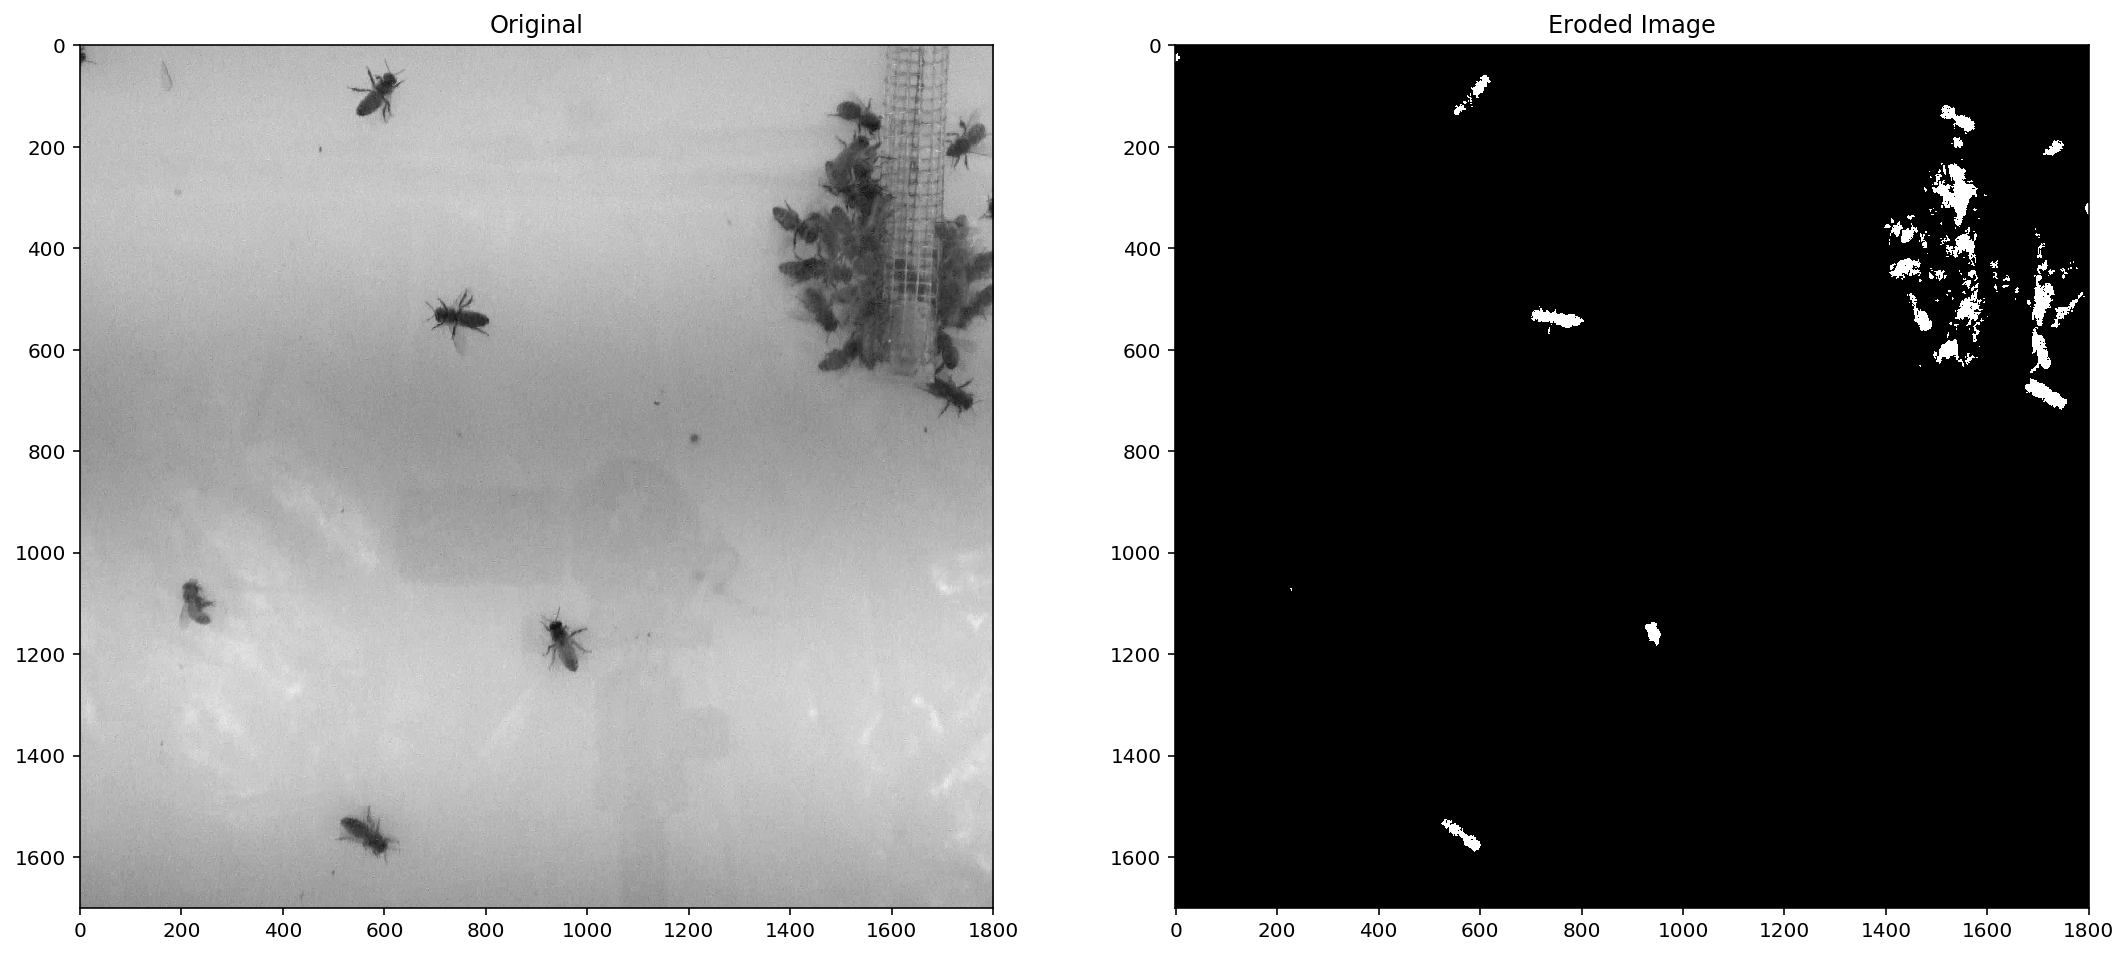

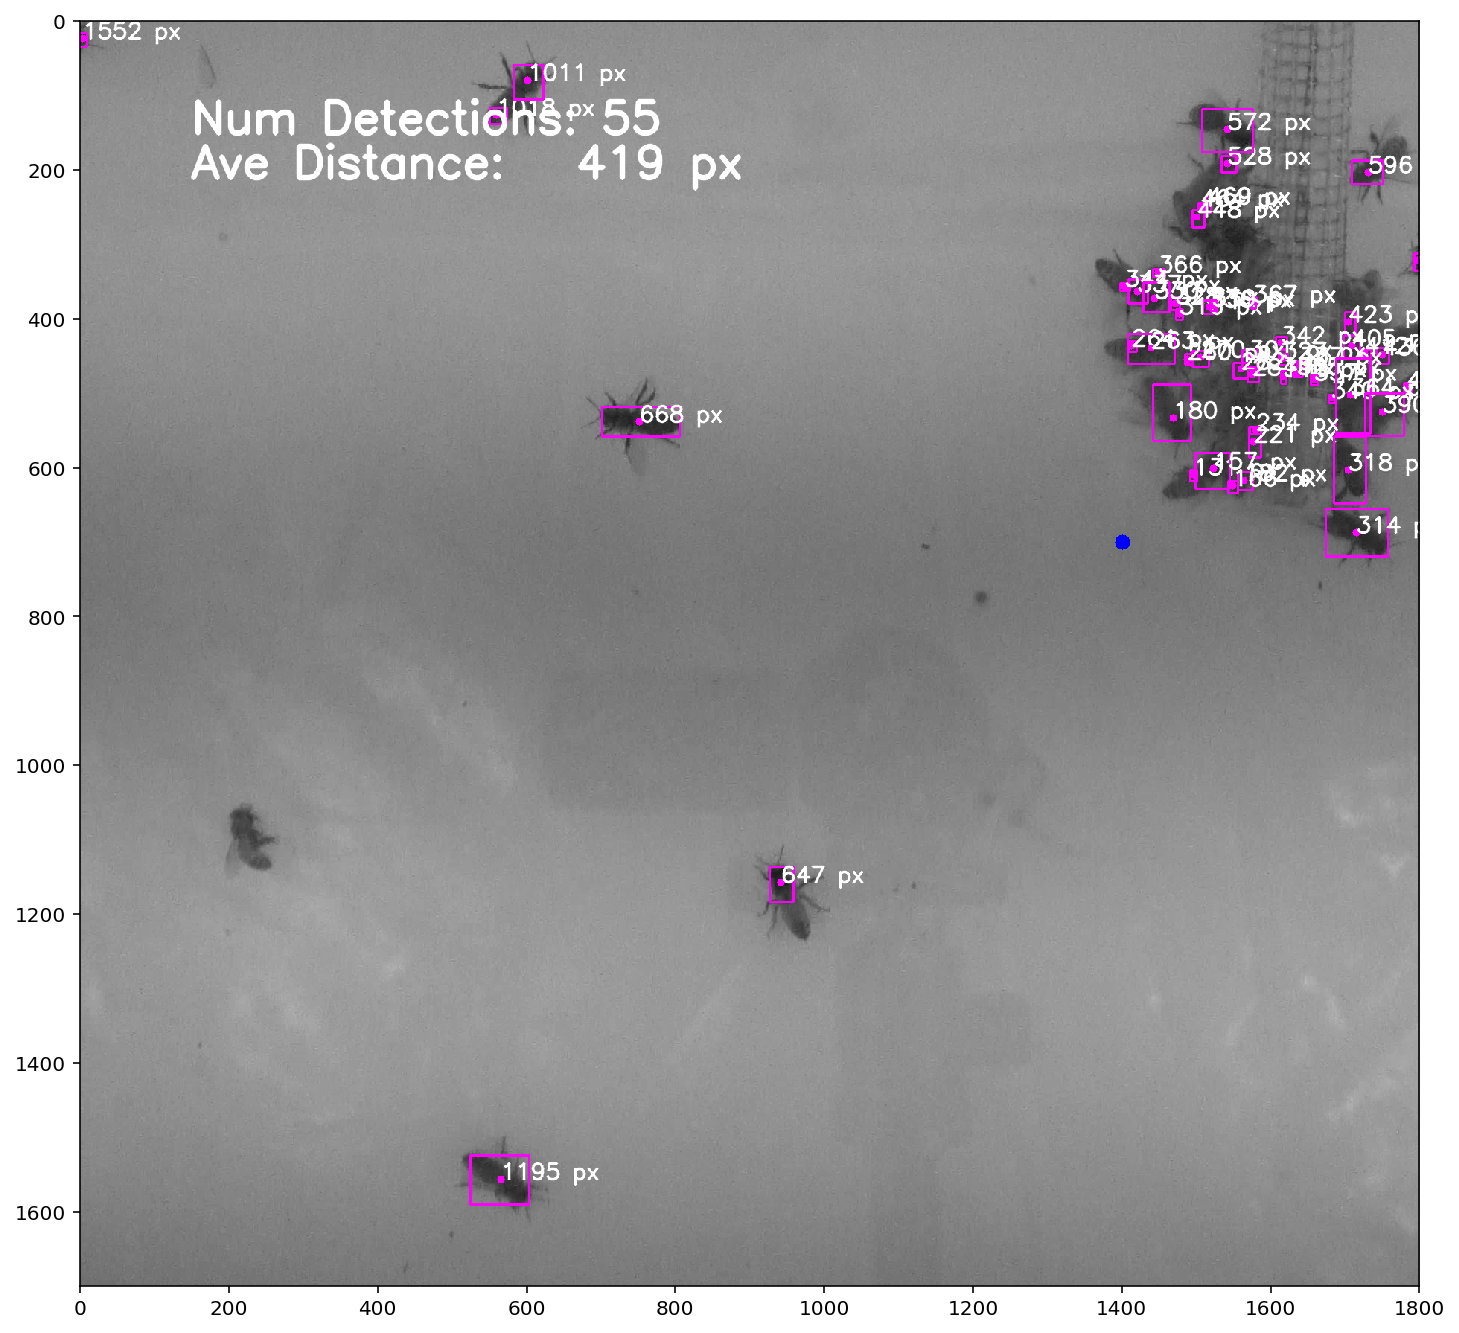

In [182]:
overlay_img = preview(14)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(overlay_img)

In [183]:
try:
    # Instantiate video streamer
    vid = utils.VideoLoader(video_path) 

    overlay_imgs = []
    for img_i, img in enumerate(vid):
        # Check if image in desired bounds
        # -----------------------------------
        if img_i < START_I:
            sys.stdout.write('\rWaiting...')
            sys.stdout.flush()
            continue
        elif img_i >= STOP_I:
            break
        # -----------------------------------
        
        # Slice image
        img = img[slice_r, slice_c]
        
        # Convert to gray-scale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Run image processing
        try:
            overlay_img = run(img, num_recursions=NUM_RECURSIONS) 
        except Exception as e:
            assert False, e
            print(f"\n**E: {e}\n")
        finally:
            # convert to bgr and append to container
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR)
            overlay_imgs.append(overlay_img)
        
        # Stdout
        sys.stdout.write(f'\rImage {img_i+1}')
        sys.stdout.flush()
        
except KeyboardInterrupt:
    print("\nKeyboard Interrupt. Finished.")
    
len(overlay_imgs)

Image 131

131

# Save to Video

In [184]:
write_vid_path = "processed_vids"
utils.imgs2vid(overlay_imgs, f"{write_vid_path}/{video_name}.mp4")

In [185]:
!open $write_vid_path